<a href="https://colab.research.google.com/github/AvantiShri/ess151project/blob/master/OceanLayersHmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/AvantiShri/ess151project.git
!gunzip ess151project/data/ocldb1560331442.7352_CTD.nc.gz

Cloning into 'ess151project'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 40 (delta 12), reused 32 (delta 7), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [0]:
from collections import defaultdict

year_to_upcast_file = {
    2016: "upcasts_16.csv",
    2017: "upcasts_17.csv",
    2018: "upcasts_18.csv",
    2019: "upcasts_19.csv",
}

temperature_key = {
    2016: ['Temperature'],
    2017: ['temp (deg C)'],
    2018: ['Temp [C]'],
    2019: ['t090C:', 't190C:']
}

salinity_key = {
    2016: ['Salinity'],
    2017: ['sal_psu'],
    2018: ['salinity'],
    2019: ['sal00:', 'sal11:']
}

fluorescence_key = {
    2016: 'fluorescence',
    2017: 'fluoro',
    2018: 'fluorescence',
    2019: 'fluroescence'
}

depth_key = {
    2016: 'Depth (m)',
    2017: 'depth (m)',
    2018: 'depth',
    2019: 'depSM:'
}

oxy_key = {
    2016: 'Oxygen (umol/kg)',
    2017: 'O2 (umol/kg)',
    2018: '[O2] (umol/L)',
    2019: 'sbeox0Mm/L:'
}

lat_key = {
    2016: 'Latitude',
    2017: 'Lat (deg N)',
    2018: 'Lat',
    2019: 'latitude:'
}

lon_key = {
    2016: 'Longitude',
    2017: 'Lon (deg E)',
    2018: 'long',
    2019: 'longitude:'
}

station_key = {
    2016: 'Station',
    2017: 'Station',
    2019: 'station'
}

def get_station_to_latlon(stations, lats, lons):
  station_to_lat = defaultdict(list)
  station_to_lon = defaultdict(list)
  for station, lat, lon in zip(stations, lats, lons):
    station_to_lat[station].append(lat)
    station_to_lon[station].append(lon)
  for station in station_to_lat:
    station_to_lat[station] = np.mean(station_to_lat[station])
    station_to_lon[station] = np.mean(station_to_lon[station])
  return station_to_lat, station_to_lon

def get_pseudostation(lat,lon):
  if (lon > -121.93 and lon < -121.91):
    return 'G1'
  elif (lat > 36.790 and lon < -121.89):
    return 'G2'
  elif (lat > 36.790 and lon < -121.87):
    return 'G3'
  elif (lat > 36.790):
    return 'G4'
  else:
    return 'blah'

In [5]:
import pandas as pd
import numpy as np

year_to_upcast_pandas = {}
year_to_phosphate_pandas = {}
for year in year_to_upcast_file:
  print(year)
  pandas_df = pd.read_csv('ess151project/data/'+year_to_upcast_file[year])
  print(pandas_df.keys())
  pandas_df['rn_temp'] = np.mean([pandas_df[x] for x in temperature_key[year]],
                                 axis=0)
  pandas_df['rn_sal'] = np.mean([pandas_df[x] for x in salinity_key[year]],
                                axis=0)
  pandas_df['rn_fluo'] = pandas_df[fluorescence_key[year]]
  pandas_df['rn_depth'] = pandas_df[depth_key[year]]
  pandas_df['rn_oxy'] = pandas_df[oxy_key[year]]
  
  
  if (year != 2018):
    station_to_lat, station_to_lon =\
      get_station_to_latlon(pandas_df[station_key[year]],
                                pandas_df[lat_key[year]],
                                pandas_df[lon_key[year]])
    pandas_df['rn_lat'] = [station_to_lat[x] for x in pandas_df[station_key[year]]]
    pandas_df['rn_lon'] = [station_to_lon[x] for x in pandas_df[station_key[year]]]
  else:
    pandas_df['rn_lat'] = pandas_df[lat_key[year]]
    pandas_df['rn_lon'] = pandas_df[lon_key[year]]

  rn_lat = pandas_df['rn_lat']
  rn_lon = pandas_df['rn_lon']
  pseudostations = [get_pseudostation(lat,lon) for lat,lon in zip(rn_lat, rn_lon)]
  pandas_df['pseudostation'] = pseudostations
    
  temp = np.array(pandas_df['rn_temp'])
  salinity = np.array(pandas_df['rn_sal'])
  Ts = np.log((298.15-temp)/(273.15-temp))

  lnCo = (5.80871 + (3.20391*Ts)+(4.17887*np.power(Ts,2) ) +(5.10006*np.power(Ts,3) )+(-0.098664*np.power(Ts,4) ) +(3.80369*np.power(Ts,5))
          +salinity*(-0.00702+(-0.0077*Ts) +(-0.0139*np.power(Ts,2))+(-0.00952*np.power(Ts,3))) +(-0.000000276*np.power(salinity,2)))
  osat = np.exp(lnCo)
  
  pandas_df['osat'] = osat
  pandas_df['AOU'] = osat - np.array(pandas_df['rn_oxy'])
  pandas_df = pandas_df[np.isnan(pandas_df['rn_lat'])==False]
  year_to_upcast_pandas[year] = pandas_df

2016
Index(['Station', 'Latitude', 'Longitude', 'Oxygen (umol/kg)', 'Temperature',
       'Salinity', 'fluorescence', 'O2 (% saturated)', 'Depth (m)'],
      dtype='object')
2017
Index(['Station', 'Lat (deg N)', 'Lon (deg E)', 'O2 (umol/kg)', 'temp (deg C)',
       'sal_psu', 'O2 (%sat)', 'fluoro', 'oxy', 'depth (m)'],
      dtype='object')
2018
Index(['Temp [C]', 'salinity', 'depth', 'fluorescence', '[O2] (umol/L)',
       'O2 (% sat)', 'Lat', 'long'],
      dtype='object')
2019
Index(['station', 't090C:', 't190C:', 'c0uS/cm:', 'c1uS/cm:', 'sal00:',
       'sal11:', 'depSM:', 'density00:', 'fluroescence', 'sbeox0Mm/L:',
       'sbeox0(%sat)', 'latitude:', 'longitude:'],
      dtype='object')


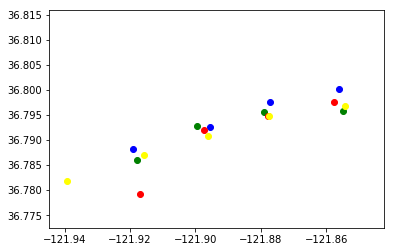

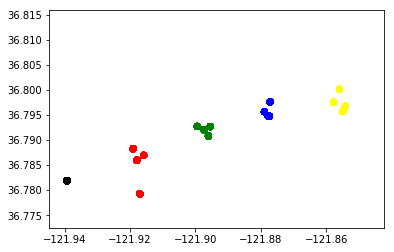

In [6]:
from matplotlib import pyplot as plt

for year,color in [(2016,'blue'),
                   (2017,'green'),
                   (2018,'red'),
                   (2019,'yellow')]:
  pandas_df = year_to_upcast_pandas[year]
  lats = pandas_df['rn_lat']
  lons = pandas_df['rn_lon']
  unique_lats_and_lons = set(zip(lons,lats))
  plt.scatter(*zip(*unique_lats_and_lons), c=color)

plt.show()

pseudostation_to_color = {
    'G1': 'red',
    'G2': 'green',
    'G3': 'blue',
    'G4': 'yellow',
    'blah': 'black'
}

for year in [2016, 2017, 2018, 2019]:
  pandas_df = year_to_upcast_pandas[year]
  lats = pandas_df['rn_lat']
  lons = pandas_df['rn_lon']
  pseudostations = pandas_df['pseudostation']
  colors = [pseudostation_to_color[pseudostation] for pseudostation in pseudostations]
  plt.scatter(lons, lats, c=colors)
plt.show()

In [0]:
import numpy as np
from scipy.interpolate import UnivariateSpline

#equations of state from view-source:http://fermi.jhuapl.edu/denscalc.html
#Compute density (kg/m3) at the surface from
# salinity (psu) and temperature (degC)
def density0(s,t):
    A =   1.001685e-04 + t * ( -1.120083e-06 + t * 6.536332e-09 )
    A = 999.842594 + t * (  6.793952e-02 + t * ( -9.095290e-03 + t * A ) )
    B =   7.6438e-05 + t * ( -8.2467e-07 + t * 5.3875e-09 )
    B =   0.824493 + t * ( -4.0899e-03 + t * B )
    C =  -5.72466e-03 + t * ( 1.0227e-04 - t * 1.6546e-06 )
    D = 4.8314e-04
    dens0 = A + s * (  B + C * np.sqrt(s) + D * s )
    return dens0

def seawater_density(s,t,p):
  #s in units of psu
  #t in units of temperature
  #p in units of dbar, which is very closely correlated with depth
  t2 = t*t
  t3 = t2*t
  t4 = t3*t

  d0 = density0(s,t);
  E = 19652.21 + 148.4206 * t - 2.327105 * t2 + 1.360477e-2 * t3 - 5.155288e-5 * t4
  F = 54.6746 - 0.603459 * t + 1.09987e-2 * t2 - 6.1670e-5 * t3
  G = 7.944e-2 + 1.6483e-2 * t - 5.3009e-4 * t2
  H = 3.239908 + 1.43713e-3 * t + 1.16092e-4 * t2 - 5.77905e-7 * t3
  I = 2.2838e-3 - 1.0981e-5 * t - 1.6078e-6 * t2
  J = 1.91075e-4
  M = 8.50935e-5 - 6.12293e-6 * t + 5.2787e-8 * t2
  N = -9.9348e-7 + 2.0816e-8 * t + 9.1697e-10 * t2

  s1p5 = s * np.sqrt(s);

  pb = p/10;

  K = (E + F*s + G*s1p5) + (H + I*s + J*s1p5) * pb + (M + N*s) * pb * pb
  d = d0 / (1 - pb/K)
  return d


#Compute adiabatic lapse rate (deg C/dBar) from salinity (psu), temperature (deg C) and pressure (dbar)
def adiabaticLapseRate(s,t,p):        
    ds = s - 35.0;
    atg = ((-2.1687e-16 * t + 1.8676e-14) * t - 4.6206e-13) * p * p
    atg = atg + (2.7759e-12 * t - 1.1351e-10 ) * ds * p
    atg = atg + (((-5.4481e-14 * t + 8.7330e-12) * t - 6.7795e-10) * t + 1.8741e-8) * p
    atg = atg + (-4.2393e-8 * t + 1.8932e-6 ) * ds
    atg = atg + ((6.6228e-10 * t - 6.8360e-8) * t + 8.5258e-6) * t + 3.5803e-5
    return atg
    
    
#Compute potential temperature (deg C) from salinity (psu), temperature (deg C) and pressure (dbar)
def potentialTemperature(s,t0,p0):
    p = p0
    t = t0
    h = 0 - p
    xk = h * adiabaticLapseRate(s,t,p)
    t = t + 0.5 * xk
    q = xk
    p = p + 0.5 * h
    xk = h * adiabaticLapseRate(s,t,p)
    t = t + 0.29289322 *(xk-q)
    q = 0.58578644 * xk + 0.121320344 * q
    xk = h * adiabaticLapseRate(s,t,p)
    t = t + 1.707106781 *(xk-q)
    q = 3.414213562 * xk - 4.121320344 * q
    p = p + 0.5 * h
    xk = h * adiabaticLapseRate(s,t,p)
    theta = t + (xk-2.0*q)/6.0
    return theta

  
def seawater_potential_density(s,t,p):
    return density0(s, potentialTemperature(s,t,p))

  
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

class Cast(object):
    def __init__(self, cast_data, lat, lon, date, time, smoothing_factor):
        self.lat = lat
        self.lon = lon
        self.date = date
        self.time = time
        self.num_obs = len(cast_data[list(cast_data.keys())[0]])
        self.cast_data = cast_data
        self.smoothing_factor = smoothing_factor
        for entry in cast_data:
            assert len(cast_data[entry])==self.num_obs
        self.potential_density = self.compute_potential_density()
        self.max_density_inversion = self.compute_max_density_inversion()
        self.compute_interpolators()
    
    def compute_potential_density(self):
        potential_density = np.array(
          [seawater_potential_density(s,t,p)
           for (s,t,p) in zip(self['Salinity'],
                              self['Temperature'],
                              (self['z'] if 'Pressure' not in self
                                         else self['Pressure']) )])
        return potential_density
    
    def compute_max_density_inversion(self):
        running_max = np.maximum.accumulate(self.potential_density)
        max_diff = np.max(running_max-self.potential_density)
        return max_diff
    
    def compute_interpolators(self):
        self.interpolator = {}
        self.derivative_interpolator = {}
        for key in self.smoothing_factor:
            if key in self:
                self.interpolator[key] = UnivariateSpline(
                    x=self['z'], y=self[key], k=4,
                    s=self.smoothing_factor[key])
                self.derivative_interpolator[key] =\
                  self.interpolator[key].derivative(1)
    
    def __len__(self):
        return self.num_obs
        
    def __contains__(self, key):
        return (key in self.cast_data)
    
    def __getitem__(self, key):
        return self.cast_data[key]
      
    def get_smoothed(self, key, values):
        return self.interpolator[key](values)
        
    def get_derivative(self, key, values):
        return self.derivative_interpolator[key](values)
      
    def get_deviation_from_running_trend(self, key, values):
        accum = ({'Temperature': np.minimum,
                  'Salinity': np.maximum,
                  'Oxygen': np.minimum,
                  'Chlorophyll': np.minimum})[key]
        smoothed_vals = self.get_smoothed(key,values)
        running_trend = accum.accumulate(smoothed_vals)
        return np.array([0]+list(smoothed_vals[1:]-running_trend[:-1]))        
      

In [10]:
!pip install netCDF4

     |████████████████████████████████| 4.1MB 5.1MB/s 
     |████████████████████████████████| 307kB 30.4MB/s 


In [0]:
import netCDF4

def read_ctd_casts(ctd_data):
    
    casts = []
    
    key_to_startidx = {
        'z': 0,
        'Temperature': 0,
        'Salinity': 0,
        'Oxygen': 0,
        'Chlorophyll': 0,
        'Pressure': 0
    }   
    for cast_idx in range(len(ctd_data['z_row_size'])):
        cast_data = {}
        for key in key_to_startidx:
            key_rowsize = int(np.array(ctd_data[key+"_row_size"][cast_idx]))
            keydata = np.array(
                ctd_data[key][key_to_startidx[key]:
                              key_to_startidx[key]+key_rowsize])
            passes = True
            if (len(keydata) < 200):
                passes = False
            else:
              if (key=='Salinity'):
                  if np.min(keydata < 30):
                      passes = False #some salinity values were v low
              if (key != 'Pressure'):
                  #only include if there are no casts
                  keyflags = np.array(ctd_data[key+"_WODflag"][
                                        key_to_startidx[key]:
                                        key_to_startidx[key]+key_rowsize])
                  if (np.sum(np.abs(keyflags)) > 0):
                      passes = False
              if (key=='z'):
                  if (np.min(keydata) > 5):
                      passes = False
            if (passes):
                cast_data[key] = keydata
            key_to_startidx[key] += key_rowsize
        #only include the cast data if z, temp and salinity are there
        if (('z' in cast_data) and ('Temperature' in cast_data)
            and ('Salinity' in cast_data)):
            casts.append(Cast(cast_data=cast_data,
                              lat=float(ctd_data['lat'][cast_idx]),
                              lon=float(ctd_data['lon'][cast_idx]),
                              date=float(ctd_data['date'][cast_idx]),
                              time=float(ctd_data['time'][cast_idx]),
                              smoothing_factor = {
                                'Temperature': 0.15,
                                'Salinity': 0.003,
                                'Oxygen': 200,
                                'Chlorophyll': 0.005}))
    return casts

ctd_data = netCDF4.Dataset("ess151project/data/ocldb1560331442.7352_CTD.nc")
public_casts = read_ctd_casts(ctd_data=ctd_data)

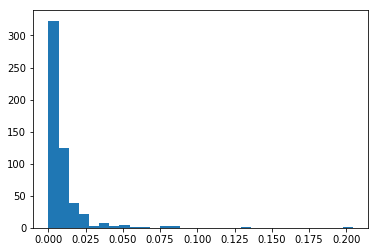

Num casts 508
Num Oxygen 77
Num Chlorophyll 51


In [193]:
from matplotlib import pyplot as plt
plt.hist([x.max_density_inversion for x in public_casts], bins=30)
plt.show()

casts = [x for x in public_casts if x.max_density_inversion < 0.03]
print("Num casts",len(casts))
print("Num Oxygen",len([x for x in casts if 'Oxygen' in x]))
print("Num Chlorophyll",len([x for x in casts if 'Chlorophyll' in x]))

(169, 217)


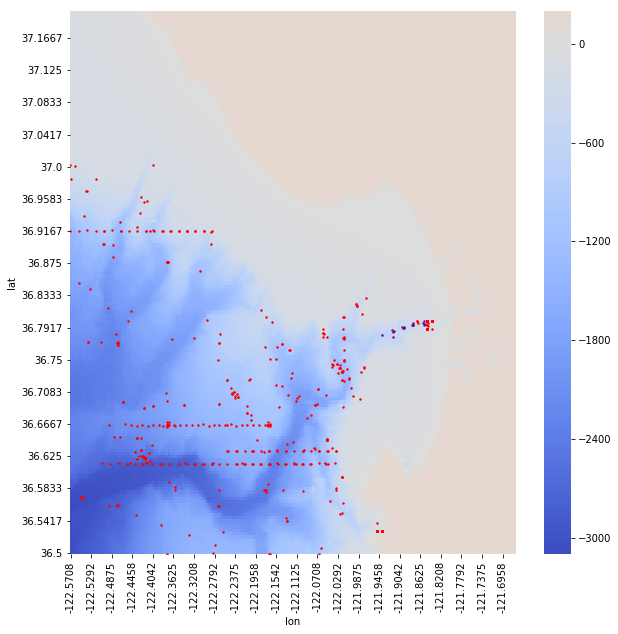

In [13]:
import seaborn as sns
import netCDF4
from matplotlib import pyplot as plt

def plot_bathymetry(topo_arr, figsize):

  topo_arr = (topo_arr*(topo_arr <= 0)+200*(topo_arr > 0))
  lats = np.round(np.array(ncv['latitude']),4)
  lons = np.round(np.array(ncv['longitude']),4)
  print(topo_arr.shape)

  d = {'lat':[], 'lon': [], 'z':[]}
  for lat_idx in range(topo_arr.shape[0]):
    for lon_idx in range(topo_arr.shape[1]):
      d['lat'].append(lats[lat_idx])
      d['lon'].append(lons[lon_idx])
      d['z'].append(topo_arr[lat_idx][lon_idx])
  d = pd.DataFrame(d).pivot("lat", "lon", "z")
  plt.figure(figsize=(10,10))
  ax = sns.heatmap(
      d,
      cmap='coolwarm', center=0,
      xticklabels=10,
      yticklabels=10)
  plt.gca().invert_yaxis()
  return ax

minlat = 36.5
maxlat = 37.2
minlon = -122.57
maxlon = -121.67
file='ess151project/data/srtm15plus.nc'
# open NetCDF data in 
nc = netCDF4.Dataset(file)
ncv = nc.variables
topo_arr = np.array(ncv['z'])

ax = plot_bathymetry(topo_arr=topo_arr, figsize=(10,10))

ax.scatter([(x.lon-minlon)*topo_arr.shape[1]/(maxlon-minlon) for x in casts],
           [(x.lat-minlat)*topo_arr.shape[0]/(maxlat-minlat) for x in casts],
           color="red", s=2)

ax.scatter([(x.lon-minlon)*topo_arr.shape[1]/(maxlon-minlon) for x in our_casts],
           [(x.lat-minlat)*topo_arr.shape[0]/(maxlat-minlat) for x in our_casts],
           color="purple", s=2)
plt.show()

In [14]:
!pip install hmmlearn

     |████████████████████████████████| 153kB 5.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/2c/b6/0e/63a865a30e21e01d04f417d8995fbfb793d6bd464707efc546
Successfully built hmmlearn


In [194]:
def prep_obs_for_hmm(casts, min_z, max_z, fixed_std=None):
  all_obs_noremap = []
  all_lengths = []
  for cast in casts:
    #plot_cast(cast)
    zobs = np.arange(min_z, max_z)
    temp_deriv = cast.get_derivative('Temperature', zobs)
    sal_deriv = cast.get_derivative('Salinity', zobs)
    all_obs_noremap.append(np.concatenate(
                            [#cast.get_deviation_from_running_trend('Temperature', zobs)[:,None],
                             (temp_deriv*(temp_deriv >= 0.02))[:,None],
                             (temp_deriv*(temp_deriv < 0.02))[:,None],
                             #cast.get_deviation_from_running_trend('Salinity', zobs)[:,None],
                             (sal_deriv*(sal_deriv >= -0.004))[:,None],
                             (sal_deriv*(sal_deriv < -0.004))[:,None],
                             #zobs[:,None]
                             #cast.get_deviation_from_running_trend('Oxygen', zobs)[:,None],
                            ],
                             axis=1))
    all_lengths.append(len(zobs))
  #remap to make sure all vals included
  concat_obs_noremap = np.concatenate(all_obs_noremap,axis=0)
  #mu = 0.0#np.median(concat_obs_noremap, axis=0)
  std = np.std(concat_obs_noremap, axis=0) if fixed_std is None else fixed_std
  all_obs = [(obs)/std[None,:] for obs in all_obs_noremap]
  concat_obs = np.concatenate(all_obs, axis=0)

  return all_obs, all_obs_noremap, std, concat_obs, all_lengths

#prepare the data for the hmm
min_z = np.ceil(np.max([np.min(x['z']) for x in casts]))
max_z = 200
print("min_z", min_z, "max_z", max_z)

(all_obs, unnorm_all_obs, std, concat_obs, all_lengths) =\
  prep_obs_for_hmm(casts=casts, min_z=min_z, max_z=max_z)
our_obs, _, _, blerg, _ = prep_obs_for_hmm(casts=our_casts, min_z=min_z,
                                    max_z=max_z, fixed_std=std)

min_z 5.0 max_z 200


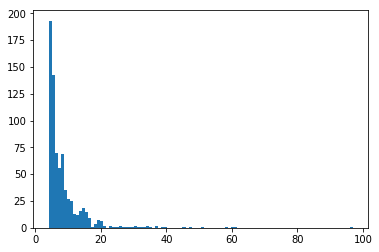

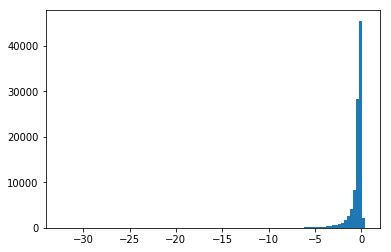

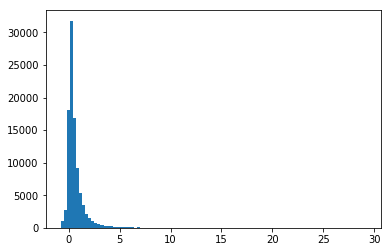

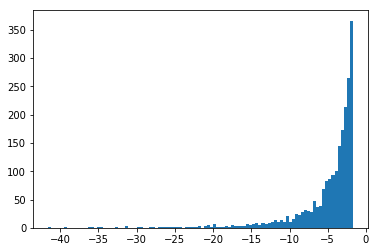

In [195]:
for i in range(concat_obs.shape[1]):
  plt.hist(concat_obs[:,i][np.abs(concat_obs[:,i]) > 0], bins=100)
  plt.show()

In [196]:
from hmmlearn import hmm
import random

n_components = 6
random.seed(1234)
the_hmm = hmm.GaussianHMM(n_components=n_components, covariance_type='diag',
                          n_iter=200, verbose=True, params='st', init_params='')

the_hmm.means_ = np.array([
    [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
    [ 0.00000000e+00, -1.00000000e+00,  1.00000000e-00,  0.00000000e+00],
    [ 0.00000000e+00, -2.50000000e+00,  2.50000000e+00,  0.00000000e+00],
    [ 0.00000000e+00, -5.00000000e+00,  5.00000000e+00,  0.00000000e+00],
    [ 5.00000000e+00, -0.00000000e+00,  3.50000000e+00, -0.00000000e+00],
    [ 0.00000000e+00, -3.50000000e+00,  0.00000000e+00, -5.00000000e+00]])
the_hmm.covars_ = np.array([
    [1.00000000e-07, 1.00000000e-02, 1.00000000e-02, 1.00000000e-07],
    [1.00000000e-07, 1.00000000e-01, 1.00000000e-01, 1.00000000e-07],
    [1.00000000e-07, 5.00000000e-01, 5.00000000e-01, 1.00000000e-07],
    [1.00000000e-07, 2.50000000e+00, 2.50000000e+00, 1.00000000e-07],
    [5.00000000e+01, 1.00000000e-07, 5.00000000e+00, 1.00000000e-07],
    [1.00000000e-07, 5.00000000e+00, 1.00000000e-07, 5.00000000e+01]])

the_hmm.startprob_ = np.array([1.0/n_components]*n_components)
the_hmm.transmat_ = np.array(np.eye(n_components)*0.8
                             + (1-np.eye(n_components))*0.2*(1/(n_components-1)))
the_hmm.fit(concat_obs, all_lengths)

#annotate all the regions
def get_annot_chunks(viterbi_annot, min_z):
  state_to_chunks = defaultdict(list)
  last_state = None
  last_state_transidx = min_z
  for idx,state in enumerate(list(viterbi_annot)+[None]):
    if (state != last_state):
      if (last_state is not None):
        state_to_chunks[last_state].append((last_state_transidx, idx+min_z))
        last_state_transidx = idx+min_z
    last_state = state
  return state_to_chunks

def annotate(cast, min_z, max_z, fixed_std):
  norm_hmm_obs = prep_obs_for_hmm([cast], min_z, max_z, fixed_std=fixed_std)[0][0]
  viterbi_annotations = the_hmm.predict(norm_hmm_obs)
  map_annotations = the_hmm.score_samples(norm_hmm_obs)[1]
  annot_chunks = get_annot_chunks(viterbi_annotations, min_z)
  cast.annot_chunks = annot_chunks
  cast.map_annotations = map_annotations
  cast.annot_min_z = min_z
  cast.norm_hmm_obs = norm_hmm_obs
  
for cast in casts:
  annotate(cast, min_z=min_z, max_z=max_z, fixed_std=std)
for cast in our_casts:
  annotate(cast, min_z=min_z, max_z=max_z, fixed_std=std)

         1 -2584879688.2029             +nan
         2 -2584866862.0511      +12826.1518
         3 -2584866715.0196        +147.0316
         4 -2584866679.0350         +35.9846
         5 -2584866667.0898         +11.9451
         6 -2584866662.5678          +4.5220
         7 -2584866660.7067          +1.8612
         8 -2584866659.9003          +0.8064
         9 -2584866659.5399          +0.3603
        10 -2584866659.3758          +0.1642
        11 -2584866659.3000          +0.0758
        12 -2584866659.2646          +0.0353
        13 -2584866659.2480          +0.0166
        14 -2584866659.2402          +0.0079


In [197]:
from collections import Counter
all_annotations = [the_hmm.predict(np.array(x)) for x in all_obs]
Counter(np.concatenate(all_annotations))

Counter({0: 35678, 1: 51741, 2: 6586, 3: 2198, 4: 749, 5: 2108})

[0. 0. 0. 0. 5. 0.]


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


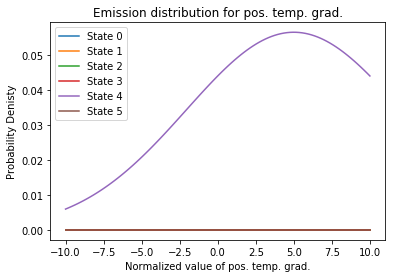

[ 0.  -1.  -2.5 -5.  -0.  -3.5]


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


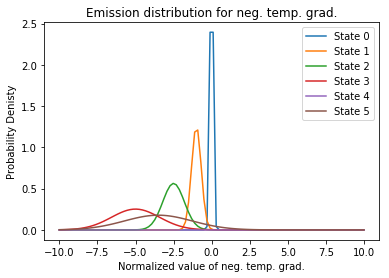

[0.  1.  2.5 5.  3.5 0. ]


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


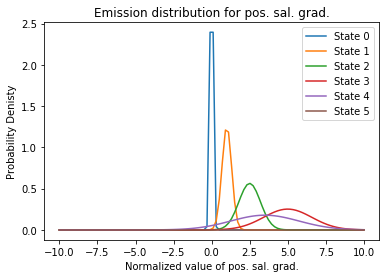

[ 0.  0.  0.  0. -0. -5.]


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


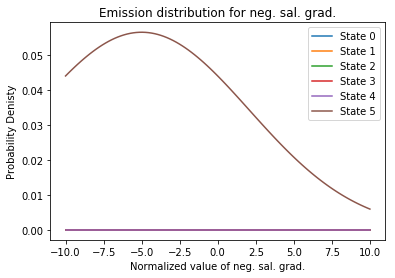

In [198]:
from matplotlib import pyplot as plt
from scipy.stats import norm

feature_idx_to_name = {
    0: "pos. temp. grad.",
    1: "neg. temp. grad.",
    2: "pos. sal. grad.",
    3: "neg. sal. grad."
}

varsmat = np.array([np.diag(x) for x in the_hmm.covars_])
#plot the distributions for the different states, to visualize them
intervals = np.linspace(-10.0, 10.0, 100)
for feature_idx in range(concat_obs.shape[1]):
  print(the_hmm.means_[:,feature_idx])
  handles = []
  for state_idx in range(n_components):
    pdfs = norm.pdf(intervals, loc=the_hmm.means_[state_idx, feature_idx],
                    scale=np.sqrt(varsmat[state_idx,feature_idx]))
    handle = plt.plot(intervals, pdfs)
    handles.append(handle)
  plt.legend(handles, labels=["State "+str(x) for x in range(n_components)])
  plt.gca().set_xlabel("Normalized value of "+feature_idx_to_name[feature_idx])
  plt.gca().set_ylabel("Probability Denisty")
  plt.title("Emission distribution for "+feature_idx_to_name[feature_idx])
  plt.show()


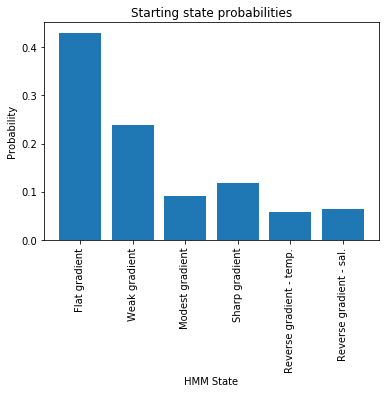

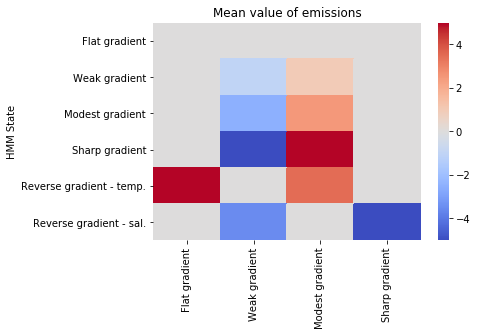

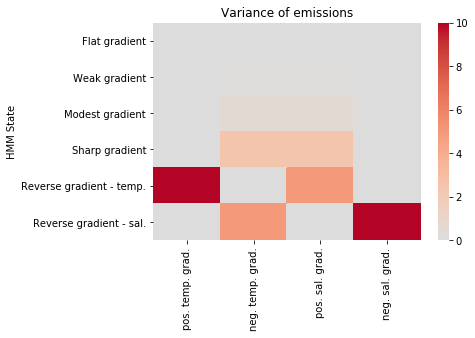

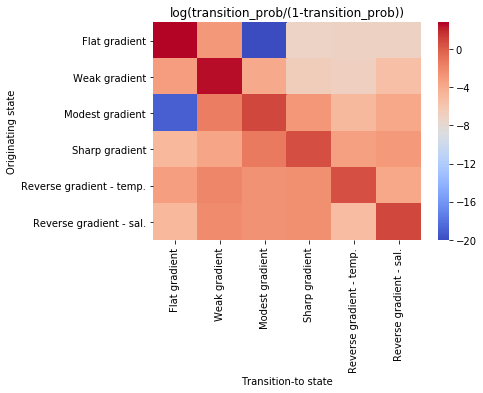

In [199]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import logit

state_idx_to_name = {
    0: "Flat gradient",
    1: "Weak gradient",
    2: "Modest gradient",
    3: "Sharp gradient",
    4: "Reverse gradient - temp.",
    5: "Reverse gradient - sal."
}

#print(the_hmm.startprob_)
plt.bar(np.arange(n_components), the_hmm.startprob_)
plt.xlabel("HMM State")
plt.gca().set_xticklabels(
    ['']+[state_idx_to_name[x] for x in range(n_components)],
    rotation="vertical")
plt.ylabel("Probability")
plt.title("Starting state probabilities")
plt.show()
sns.heatmap(the_hmm.means_, center=0, cmap='coolwarm')
plt.gca().set_xticklabels(
    [state_idx_to_name[x] for x in range(n_components)],
    rotation="vertical")
plt.ylabel("HMM State")
plt.gca().set_yticklabels(
    [state_idx_to_name[x] for x in range(n_components)],
    rotation="horizontal")
plt.title("Mean value of emissions")
plt.show()
covarsmat = np.array([np.diag(x) for x in the_hmm.covars_])
sns.heatmap(np.minimum(covarsmat,10), center=0, cmap='coolwarm')
plt.gca().set_xticklabels(
    [feature_idx_to_name[x] for x in range(4)],
    rotation="vertical")
plt.ylabel("HMM State")
plt.gca().set_yticklabels(
    [state_idx_to_name[x] for x in range(n_components)],
    rotation="horizontal")
plt.title("Variance of emissions")
plt.show()

#for idx in range(the_hmm.means_.shape[1]):
#  plt.bar(np.arange(len(the_hmm.means_[:,idx])), the_hmm.means_[:,idx])
#  plt.show()
sns.heatmap(logit(the_hmm.transmat_), cmap='coolwarm', vmin=-20)
plt.ylabel("Originating state")
plt.gca().set_yticklabels(
    [state_idx_to_name[x] for x in range(n_components)],
    rotation="horizontal")
plt.xlabel("Transition-to state")
plt.gca().set_xticklabels(
    [state_idx_to_name[x] for x in range(n_components)],
    rotation="vertical")
plt.title("log(transition_prob/(1-transition_prob))")
plt.show()

In [0]:
#annotate all the regions
def compute_mld(cast):
  assert hasattr(cast, 'annot_chunks')
  annot_chunks = cast.annot_chunks
  #first identify start of mixed layer
  ml_start = np.inf
  #If has an instance of state 0 within first 20m
  if (annot_chunks[0][0][0] <= 20):
    ml_start = annot_chunks[0][0][0]
  else:
    if (annot_chunks[1][0][0] <= 20):
      ml_start = annot_chunks[1][0][0]
  if (ml_start <= 20):
    #Look for clean breaks
    first_break = np.inf
    if 2 in annot_chunks:
      first_break = min([x[0]
                     for x in annot_chunks[2] if
                     x[0] > ml_start]+[first_break])
    if 3 in annot_chunks:
      first_break = min([x[0]
                     for x in annot_chunks[2] if
                     x[0] > ml_start]+[first_break])
    if (first_break <= 150): # if the break occurs within first 100 m
      mld = first_break #use that as the mld
    else:
      if 1 in annot_chunks: #check for weak gradients
        first_break = min([x[0]
                     for x in annot_chunks[1] if
                     x[0] > ml_start]+[first_break])
      if (first_break <= 150): # if the break occurs within first 100 m
        mld = first_break #use that as the mld
      else: #use the end of the first flat state
        mld = annot_chunks[0][0][1]
  else: #set mld to 0
    mld = 0
  
  cast.mld = mld
  #identify breaks occuring at least 20m after mixed layer, if any
  state_to_breaks_after_mld = {}
  for state in [2,3]:
    breaks_after_mld = [x for x in annot_chunks[state]
                        if x[0] > mld+20]
    if (len(breaks_after_mld) > 0):
      state_to_breaks_after_mld[state] = breaks_after_mld
  cast.breaks_after_mld = state_to_breaks_after_mld
  if (len(state_to_breaks_after_mld.keys()) > 0):
    cast.has_breaks_after_mld = True
  else:
    cast.has_breaks_after_mld = False
  
for cast in casts:
  compute_mld(cast)
for cast in our_casts:
  compute_mld(cast)

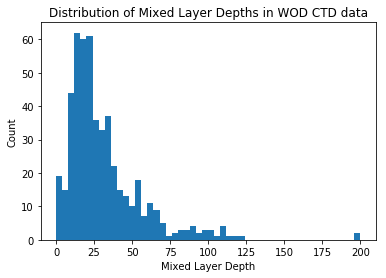

0.5866141732283464

In [224]:
plt.hist([cast.mld for cast in casts], bins=50)
plt.xlabel("Mixed Layer Depth")
plt.ylabel("Count")
plt.title("Distribution of Mixed Layer Depths in WOD CTD data")
plt.show()

np.mean([x.has_breaks_after_mld for x in casts])

306
19990115.0 36.626678466796875 -122.4241714477539


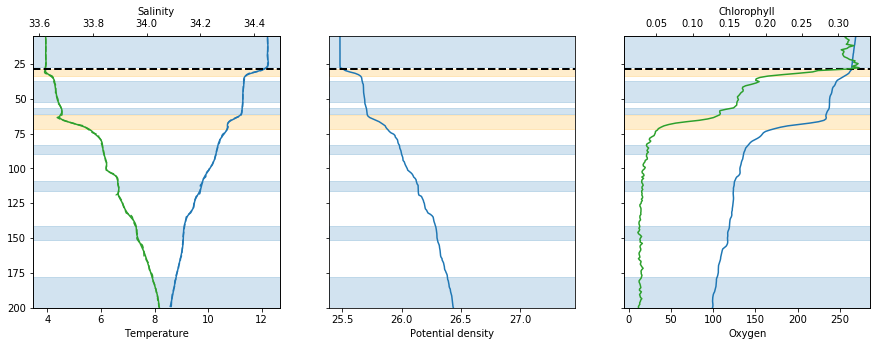

308
19991116.0 36.724369049072266 -122.02117919921875


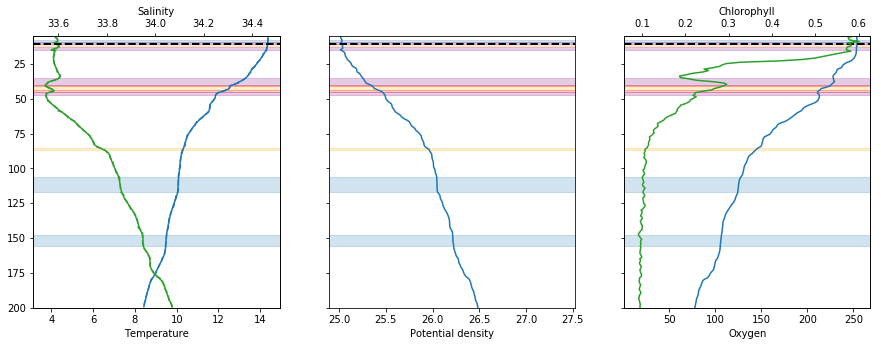

310
19991117.0 36.673561096191406 -122.20355987548828


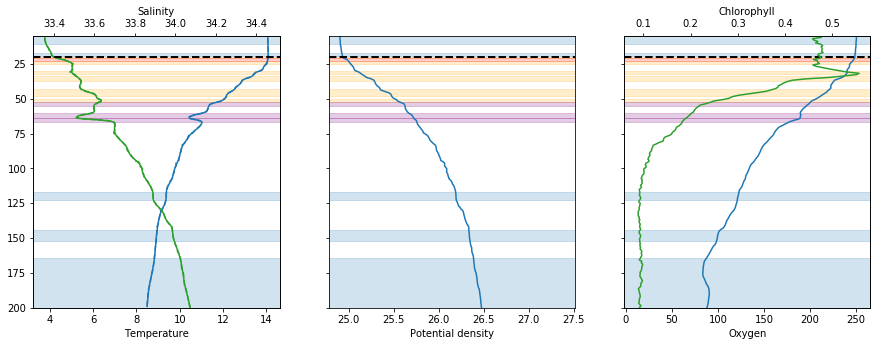

311
19991117.0 36.61573028564453 -122.42362976074219


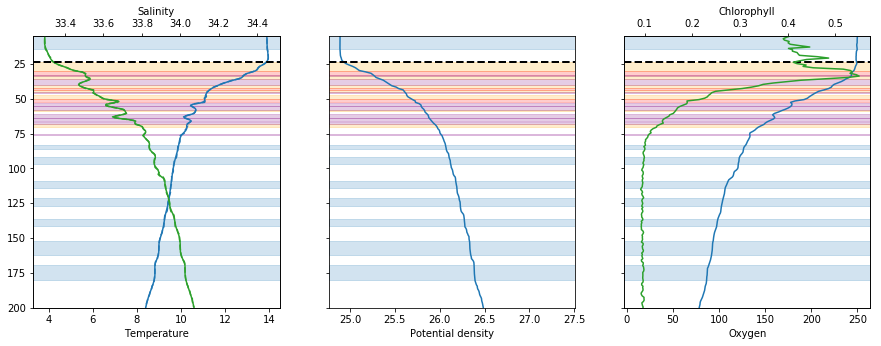

313
20000730.0 36.546138763427734 -122.1333236694336


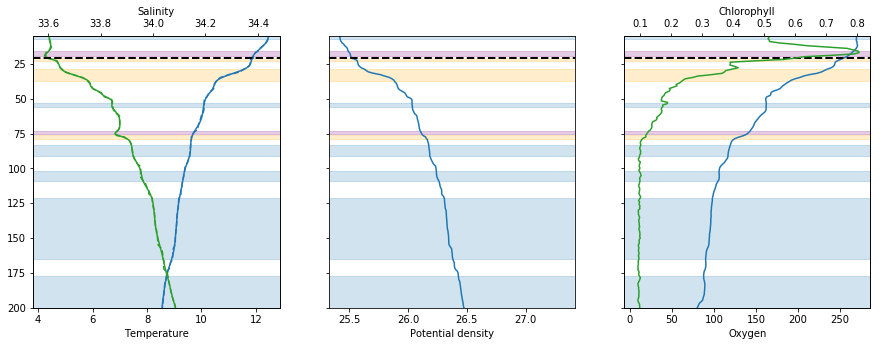

343
20010206.0 36.73326110839844 -122.02839660644531


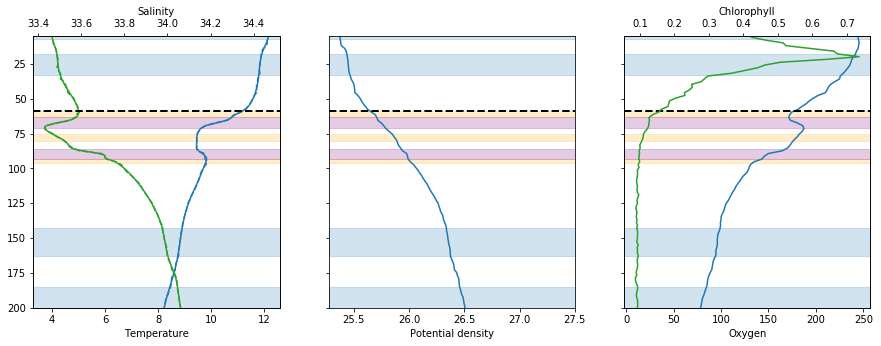

344
20010206.0 36.67985916137695 -122.20349884033203


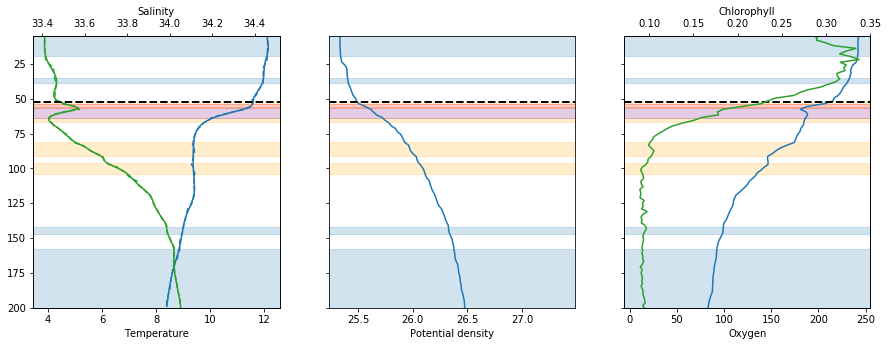

381
20010802.0 36.69786071777344 -122.37394714355469


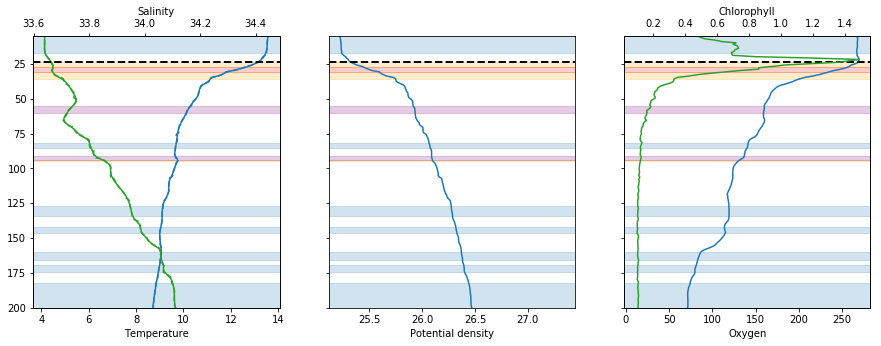

421
20020716.0 36.623329162597656 -122.4175033569336


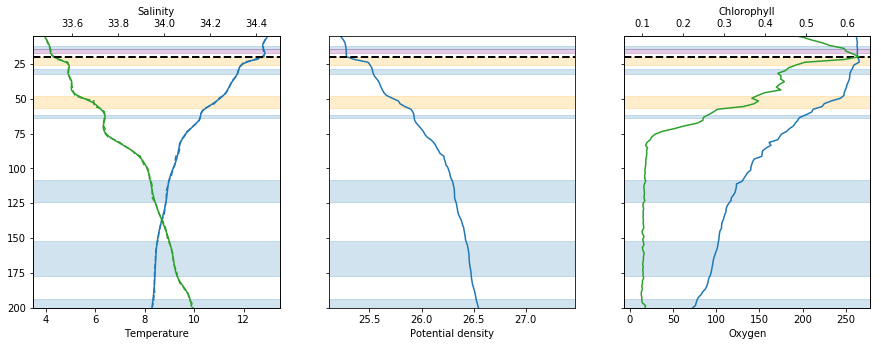

452
20030128.0 36.70949935913086 -122.23799896240234


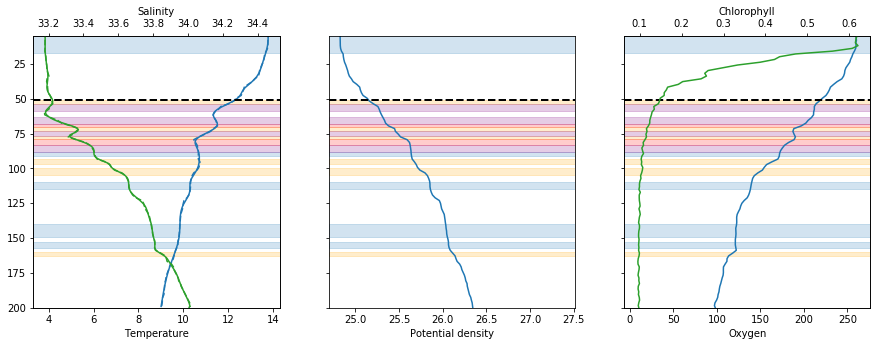

453
20030128.0 36.70949935913086 -122.23799896240234


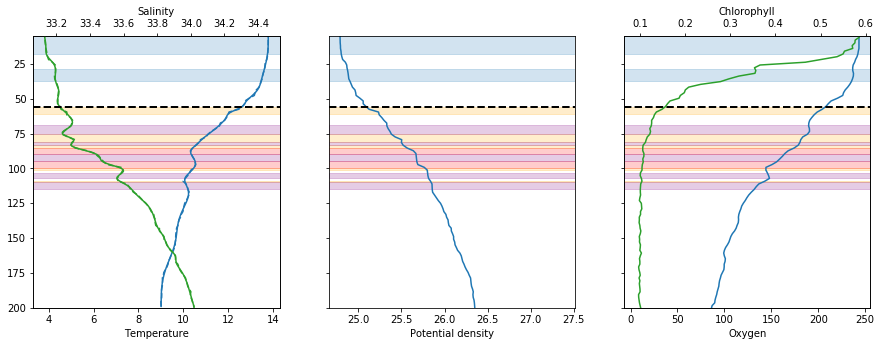

454
20030128.0 36.62466812133789 -122.42066955566406


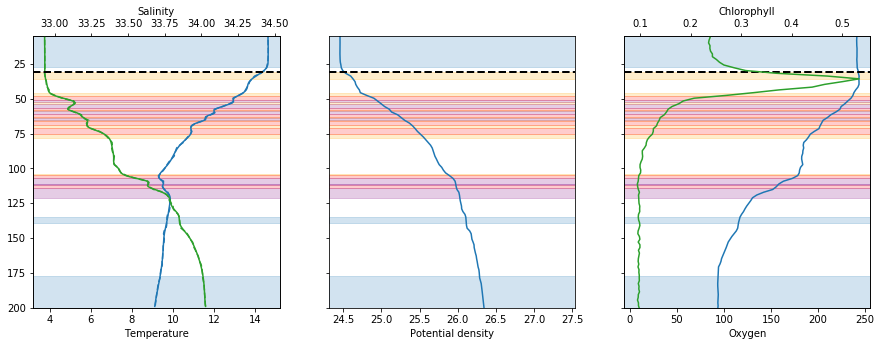

455
20030128.0 36.62466812133789 -122.42066955566406


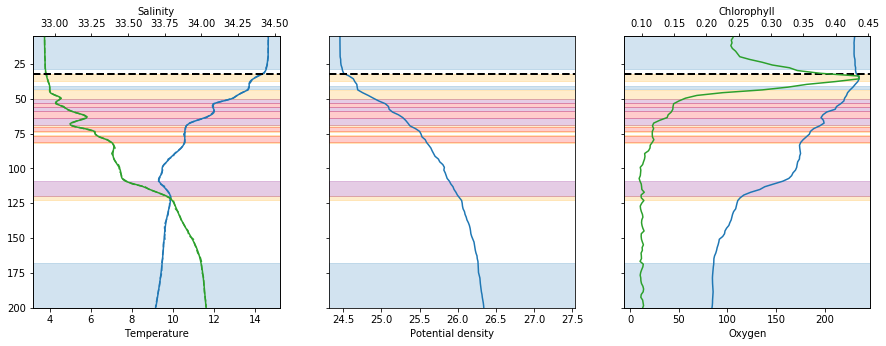

476
20060120.0 36.6231803894043 -122.4349365234375


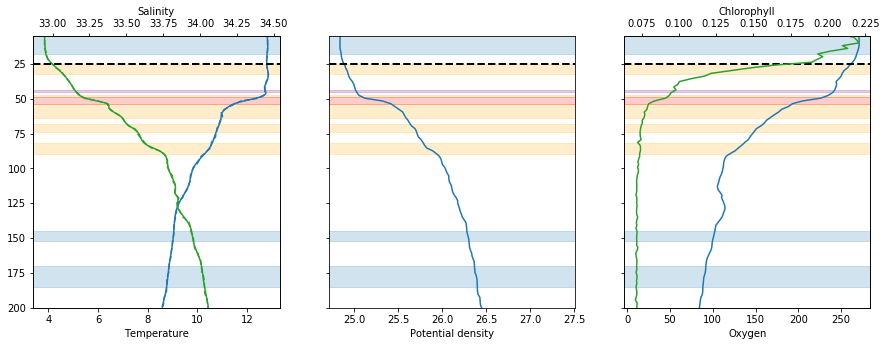

477
20060120.0 36.6231803894043 -122.4349365234375


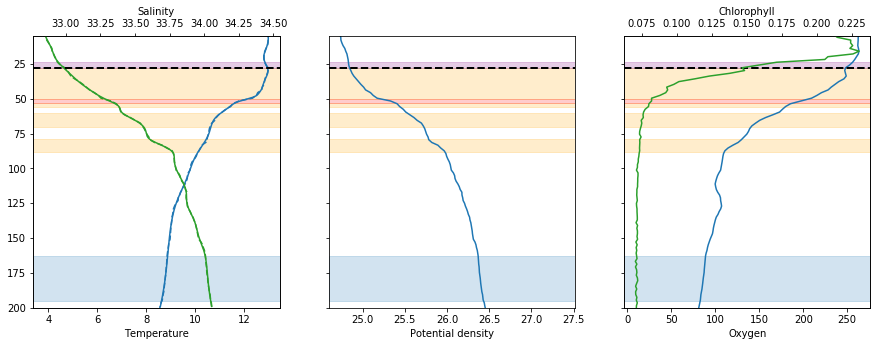

501
20080123.0 36.63513946533203 -122.07433319091797


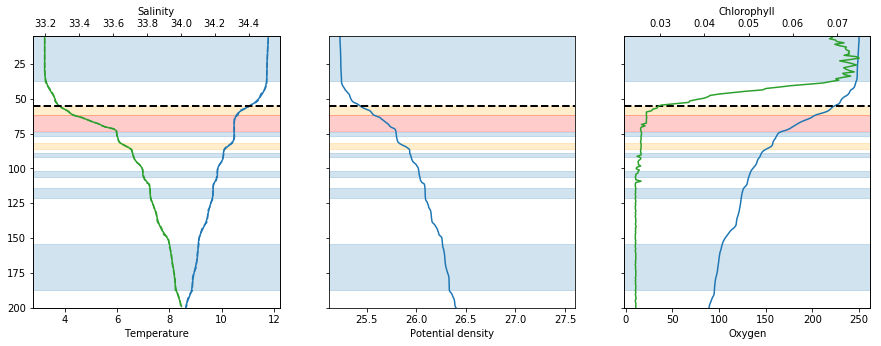

502
20080124.0 36.64400100708008 -122.1202163696289


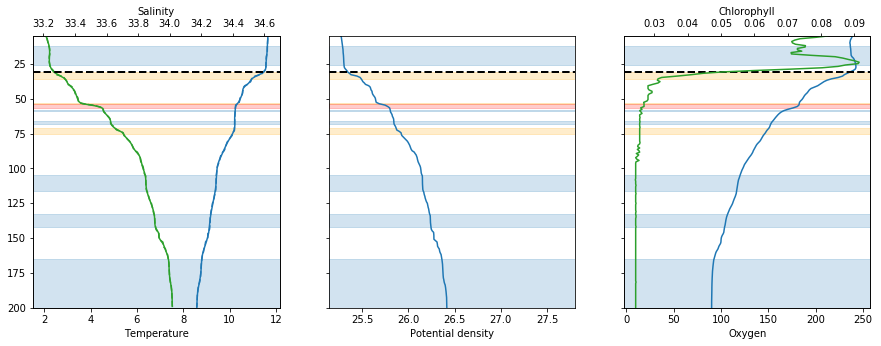

503
20080124.0 36.697059631347656 -122.11369323730469


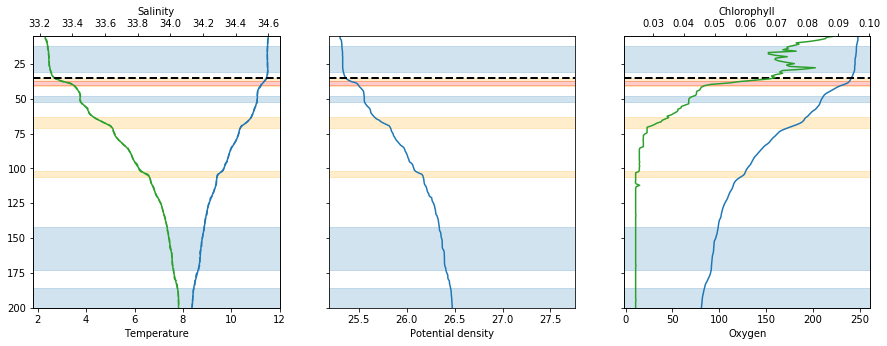

504
20080124.0 36.569091796875 -122.04493713378906


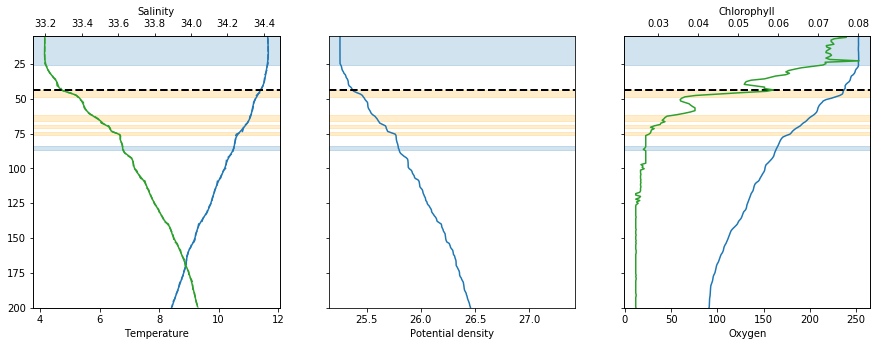

506
20080130.0 36.72431945800781 -122.25314331054688


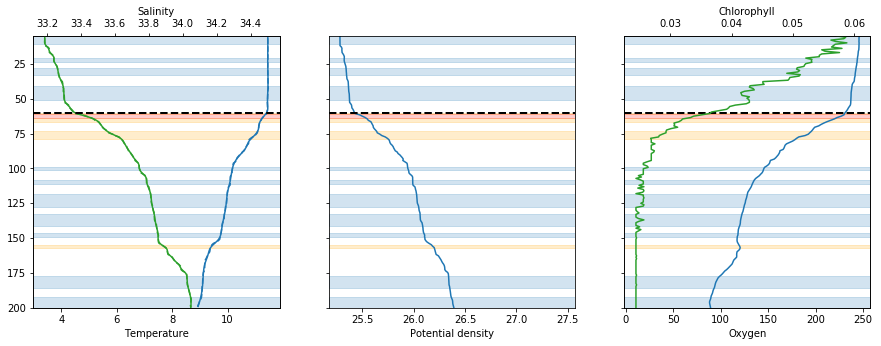

In [218]:
from scipy.special import logit
from collections import defaultdict

def get_annot_chunks(viterbi_annot, min_z):
  state_to_chunks = defaultdict(list)
  last_state = None
  last_state_transidx = min_z
  for idx,state in enumerate(list(viterbi_annot)+[None]):
    if (state != last_state):
      if (last_state is not None):
        state_to_chunks[last_state].append((last_state_transidx, idx+min_z))
        last_state_transidx = idx+min_z
    last_state = state
  return state_to_chunks


def capped_logit(v):
  return np.minimum(np.maximum(-20,logit(v)),20)


def color_ax_with_boxes(ax, annot_chunks): 
  for idx,color in [(0,'C0'), (2,'orange'),
                    (3,'red'), (4,'purple'), (5,'purple')]:
    for (ymin, ymax) in annot_chunks[idx]:
      ax.axhspan(ymin=ymin, ymax=ymax, color=color, alpha=0.2)
  

def plot_cast_with_state_highlight(cast, show_mld=True):
  
  print(cast.date, cast.lat, cast.lon) 
  annot_chunks = cast.annot_chunks
  fig,ax = plt.subplots(1,3, sharey=True, figsize=(15,5))
  z_intervals = np.arange(len(cast.map_annotations))+cast.annot_min_z
  
  ax[0].plot(cast['Temperature'], cast['z'], color='C0', linestyle="--")
  ax[0].plot(cast.get_smoothed('Temperature',z_intervals), z_intervals, color='C0')
  ax[0].set_xlabel("Temperature")
  color_ax_with_boxes(ax=ax[0], annot_chunks=annot_chunks)
  
  salax = ax[0].twiny() #salinity axis
  salax.plot(cast['Salinity'], cast['z'], color='C2', linestyle="--")
  salax.plot(cast.get_smoothed('Salinity',z_intervals), z_intervals, color='C2')
  salax.set_xlabel("Salinity")  
  if (show_mld):
    salax.axhline(cast.mld, color="black", linewidth=2, linestyle="--")
  
  ax[1].plot(cast.potential_density-1000, cast['z'])
  color_ax_with_boxes(ax=ax[1], annot_chunks=annot_chunks)
  ax[1].set_xlabel("Potential density") 
  if (show_mld):
    ax[1].axhline(cast.mld, color="black", linewidth=2, linestyle="--")
  
  if ('Oxygen' in cast):
    ax[2].plot(cast['Oxygen'], cast['z'])
    color_ax_with_boxes(ax=ax[2], annot_chunks=annot_chunks)
    ax[2].set_xlabel("Oxygen")
    if (show_mld):
      ax[2].axhline(cast.mld, color="black", linewidth=2, linestyle="--")
  if ('Chlorophyll' in cast):
    chlorax = ax[2].twiny()
    chlorax.plot(cast['Chlorophyll'], cast['z'], color='C2')  
    chlorax.set_xlabel("Chlorophyll")
  if ('Fluorescence' in cast):
    chlorax = ax[2].twiny()
    chlorax.plot(cast['Fluorescence'], cast['z'], color='C2')  
    chlorax.set_xlabel("Fluorescence")
   
  """ax[3].plot(capped_logit(cast.map_annotations[:,0]), z_intervals, color='C0')
  ax[3].plot(capped_logit(cast.map_annotations[:,1]), z_intervals, color='C1')
  ax[3].plot(capped_logit(cast.map_annotations[:,2]), z_intervals, color='C2')
  ax[3].plot(capped_logit(cast.map_annotations[:,3]), z_intervals, color='C3')
  ax[3].plot(capped_logit(cast.map_annotations[:,4]), z_intervals, color='C4')
  ax[3].plot(capped_logit(cast.map_annotations[:,5]), z_intervals, color='C5')"""
  
    
  ax[0].set_ylim(max_z, min_z)
  plt.show()
    
for cast_idx,cast in enumerate(casts):
  if ('Oxygen' in cast and 'Chlorophyll' in cast and cast.has_breaks_after_mld):
    print(cast_idx)
    plot_cast_with_state_highlight(cast)


In [0]:
#create cast objects from the class data

our_casts = []

for year in [2016, 2017, 2018, 2019]:
  for station in ['G1', 'G2', 'G3', 'G4', 'blah']:
    pandas_df = year_to_upcast_pandas[year]
    station_mask = pandas_df['pseudostation']==station
    if (sum(station_mask) > 0):
      masked_df = pandas_df[station_mask]
      lat = np.mean(masked_df['rn_lat'])
      lon = np.mean(masked_df['rn_lon'])
      date = str(year)+"0505" #possibly inaccurate month/day
      z = np.array(masked_df['rn_depth'])
      temp = np.array(masked_df['rn_temp'])
      sal = np.array(masked_df['rn_sal'])
      oxy = np.array(masked_df['rn_oxy'])
      fluor = np.array(masked_df['rn_fluo'])
      
      #need to have z strictly increasing
      sorted_z_indices = [x[0] for x in
                          sorted(enumerate(z), key=lambda x: x[1])]
      z = [z[i] for i in sorted_z_indices]
      temp = [temp[i] for i in sorted_z_indices]
      sal = [sal[i] for i in sorted_z_indices]
      oxy = [oxy[i] for i in sorted_z_indices]
      fluor = [fluor[i] for i in sorted_z_indices]
      
      our_casts.append(
          Cast(cast_data={'z':z, 'Temperature':temp,
                          'Salinity':sal, 'Oxygen':oxy, 'Fluorescence': fluor},
               lat=lat, lon=lon, date=date, time=None,
              smoothing_factor = {
                 'Temperature': 0.2 if (year==2017) else (0.3 if year==2018 else 0.15),
                 'Salinity': 0.01 if year==2017 else 0.002,
                 'Oxygen': 200,
                 'Chlorophyll': 0.005}))
      
for cast in our_casts:
  annotate(cast, min_z=min_z, max_z=max_z, fixed_std=std)   
for cast in our_casts:
  compute_mld(cast)

0
20160505 36.78824716171598 -121.91903033003392


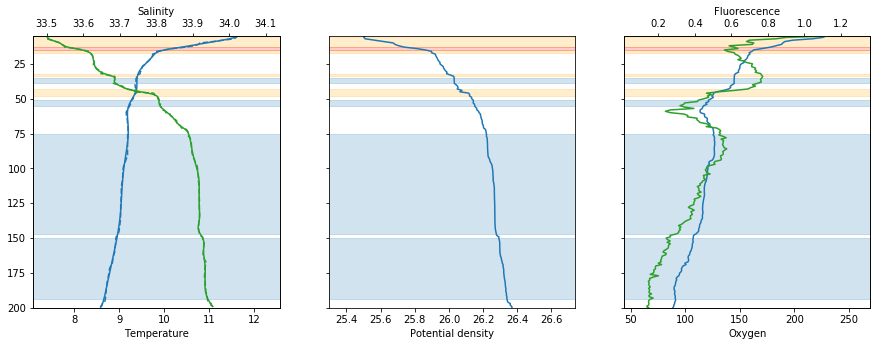

1
20160505 36.79265344827582 -121.89549068965455


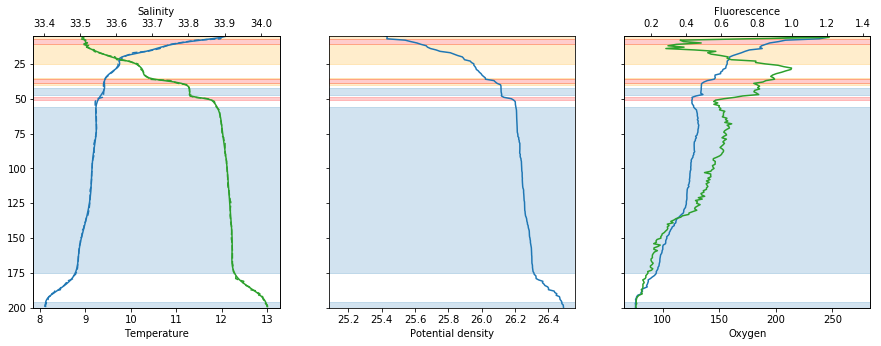

2
20160505 36.797597079207854 -121.8771415841584


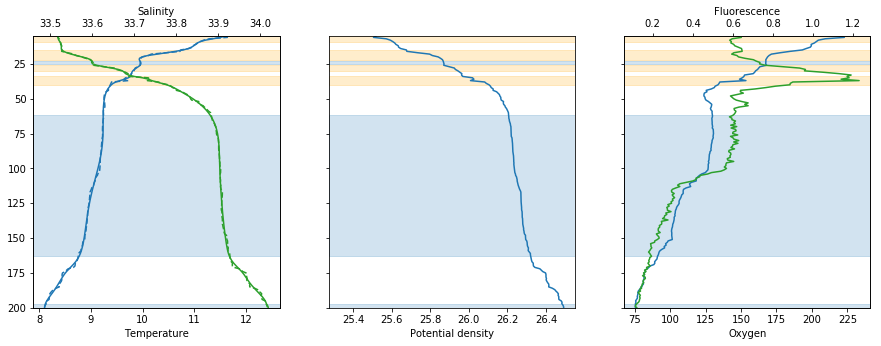

3
20160505 36.80009935323394 -121.85592164179138


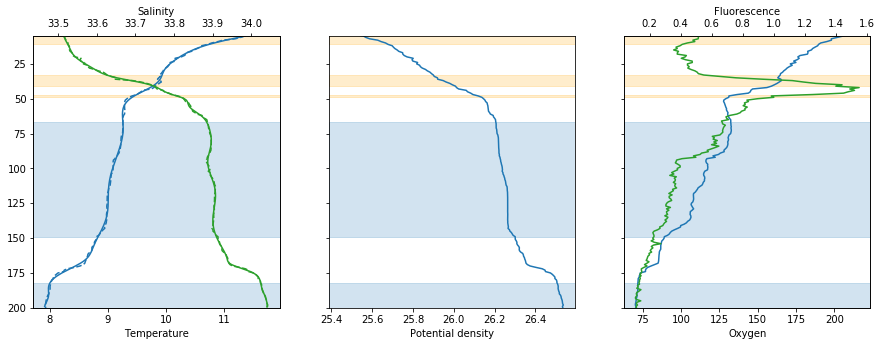

4
20170505 36.78596999999992 -121.91785000000047


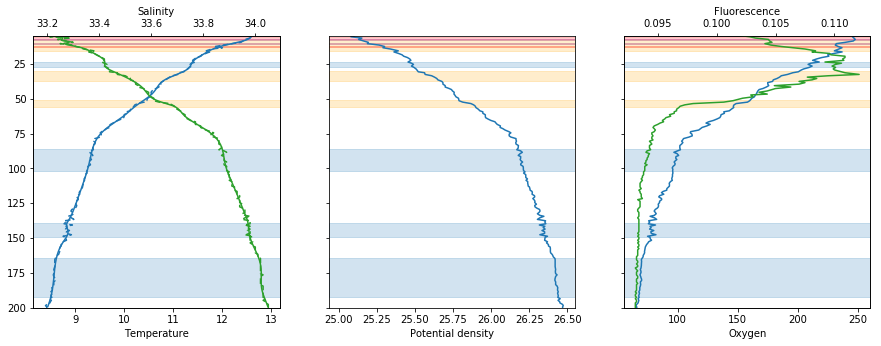

5
20170505 36.792699999999975 -121.89937999999982


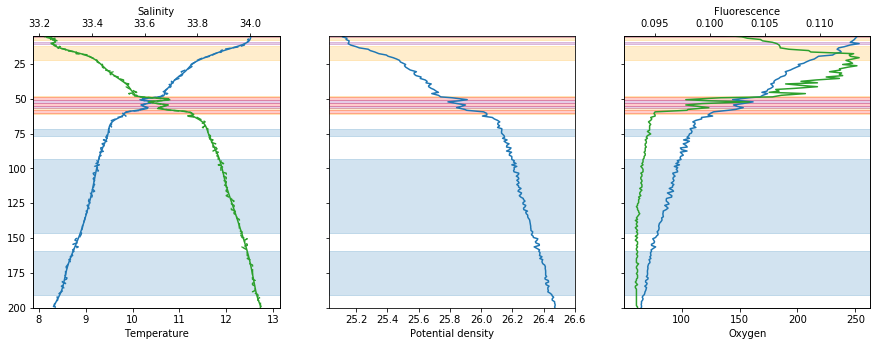

6
20170505 36.795619999999886 -121.87887000000038


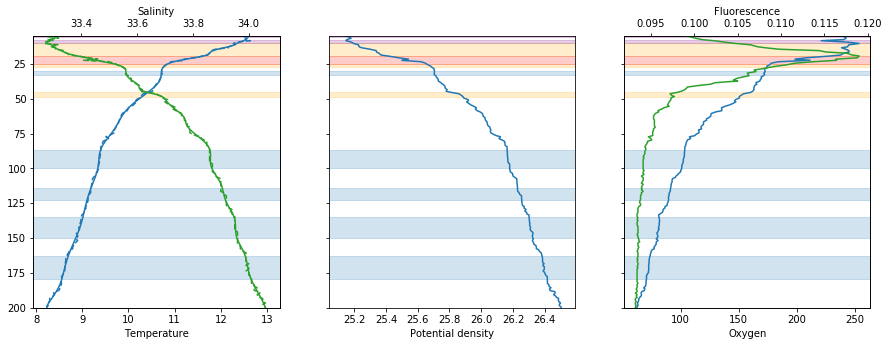

7
20170505 36.795699999999925 -121.85489999999976


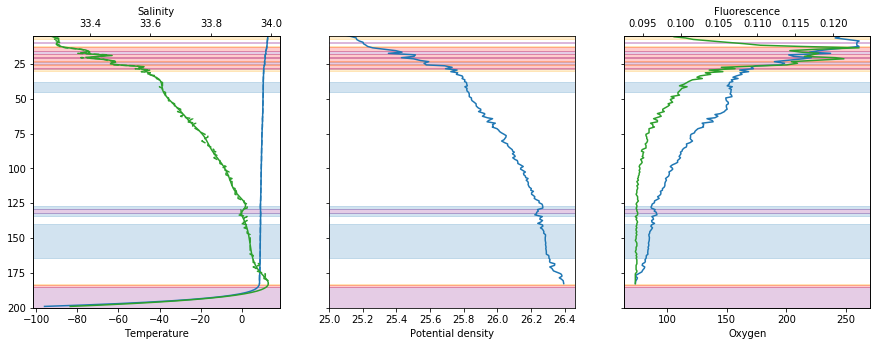

8
20180505 36.77923000000009 -121.91696000000074


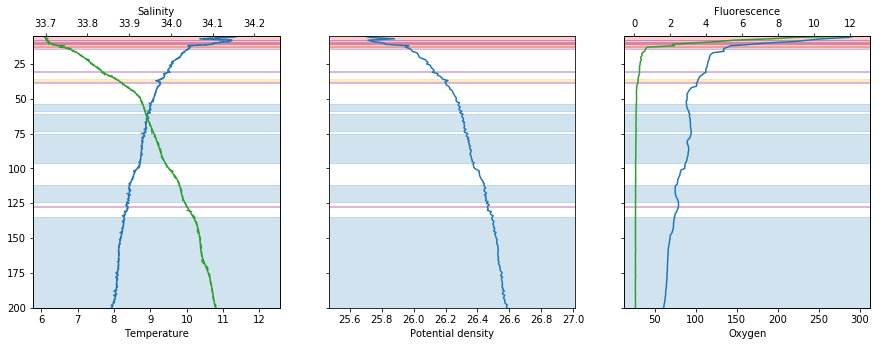

9
20180505 36.792020000000136 -121.89737999999967


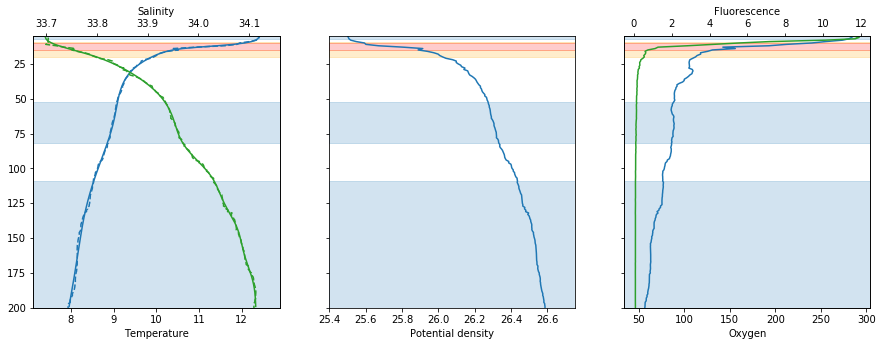

10
20180505 36.79474000000008 -121.87773000000014


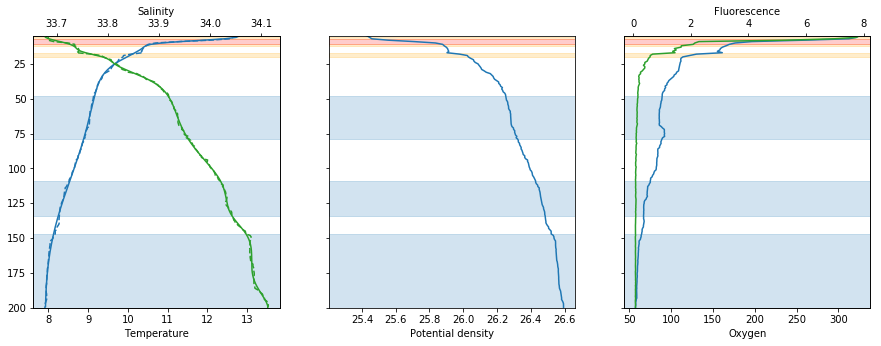

11
20180505 36.79748999999994 -121.8577399999997


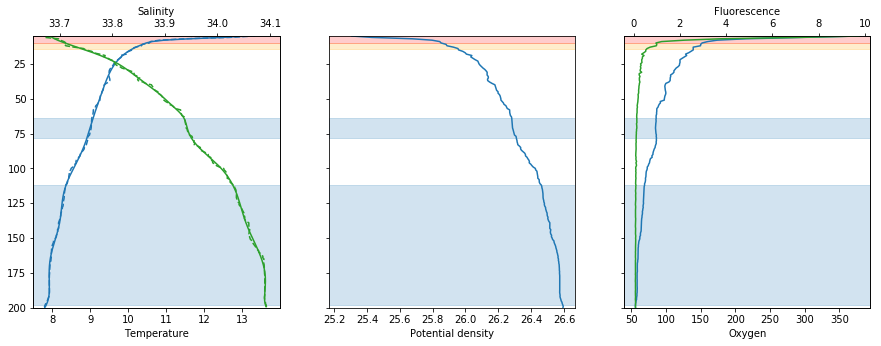

12
20190505 36.786917425742764 -121.91581539603914


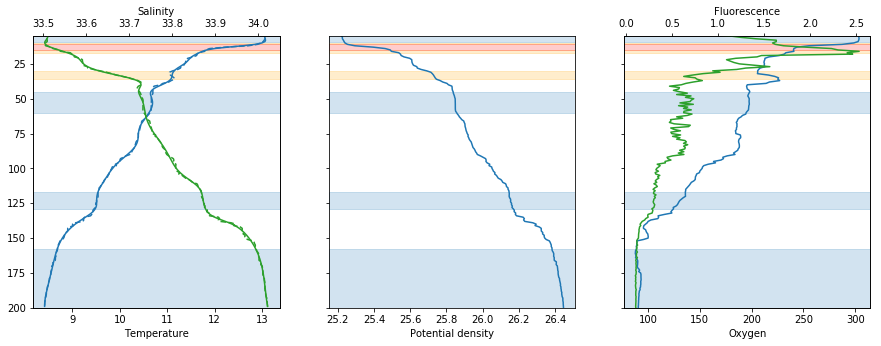

13
20190505 36.79078623762391 -121.89599202970295


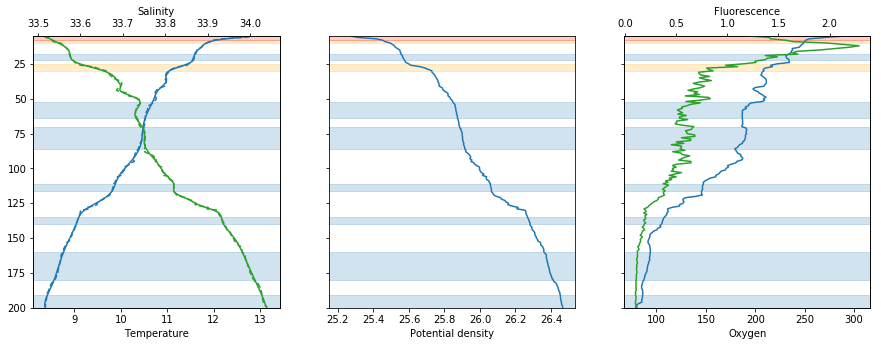

14
20190505 36.794739303482665 -121.87735900497502


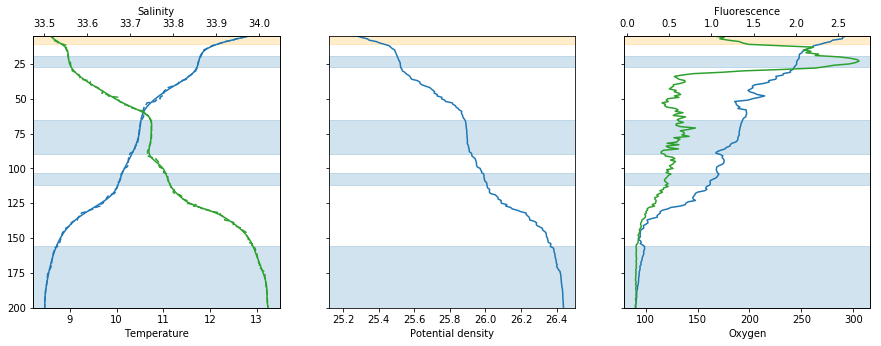

15
20190505 36.79673577114415 -121.85415621890569


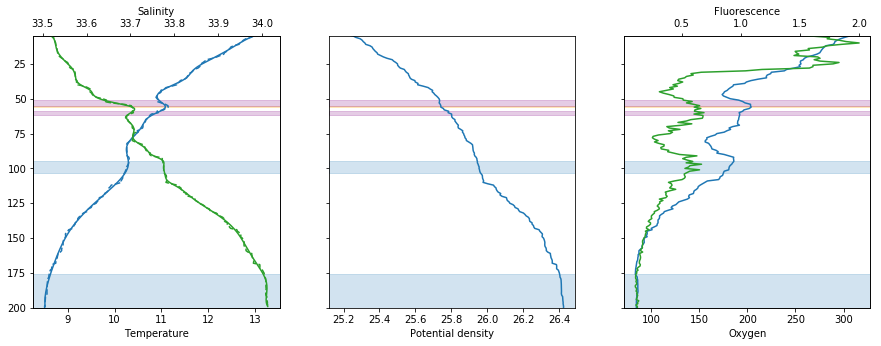

16
20190505 36.78188000000016 -121.93923000000164


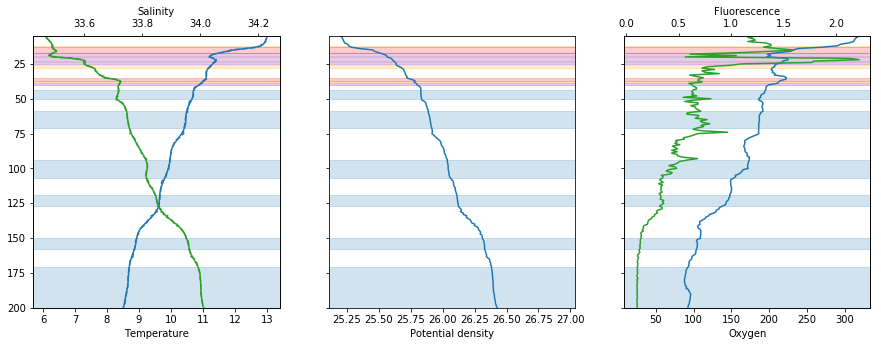

In [222]:
for cast_idx,cast in enumerate(our_casts):
  print(cast_idx)
  plot_cast_with_state_highlight(cast, show_mld=False)